In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
# from fit import rerun, likelihood
palette = sns.color_palette('tab10')
sns.set_palette(palette)
sns.set(context='paper', style='white', font='CMU Serif',
    rc={'font.size':12, 'mathtext.fontset': 'cm', 'axes.labelpad':0, 'axes.linewidth': 0.5})

# WM

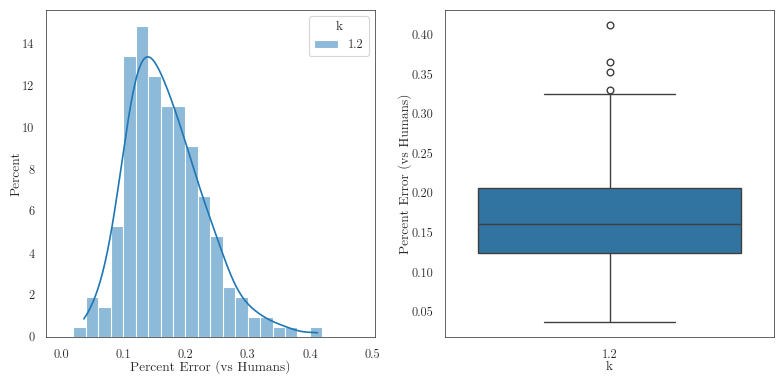

In [18]:
z05k12 = pd.read_pickle(f"data/WM_z05k12.pkl").query("type=='model-WM'")
combined = pd.concat([z05k12], ignore_index=True)

dfs = []
columns = ['type', 'sid', 'z', 'k', 'percent error']
for k in combined['k'].unique():
    for sid in combined['sid'].unique():
        subdata = combined.query("k==@k & sid==@sid")
        z = subdata['z'].unique()[0]
        errors = subdata['error'].to_numpy()
        if len(errors)==0:
            print(f"missing k={k} sid={sid}")
            continue
        percent_error = np.sum(errors) / len(errors)
        df = pd.DataFrame([['model-WM', sid, str(z), str(k), percent_error]], columns=columns)
        dfs.append(df)
reduced = pd.concat(dfs, ignore_index=True)

fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(8,4))
bins = np.arange(0.0, 0.5, 0.02)
ks = reduced['k'].unique()

sns.histplot(reduced, x='percent error', hue='k', ax=axes[0], palette=palette[:len(ks)], stat='percent', bins=bins, kde=True, common_norm=False)
sns.boxplot(reduced, x='k', y='percent error', hue='k', ax=axes[1], palette=palette[:len(ks)])
axes[0].set(xlabel="Percent Error (vs Humans)") 
axes[1].set(xlabel="k", ylabel='Percent Error (vs Humans)') 
plt.tight_layout()
fig.savefig("plots/wm_errors_zk.png", dpi=600)

# RL

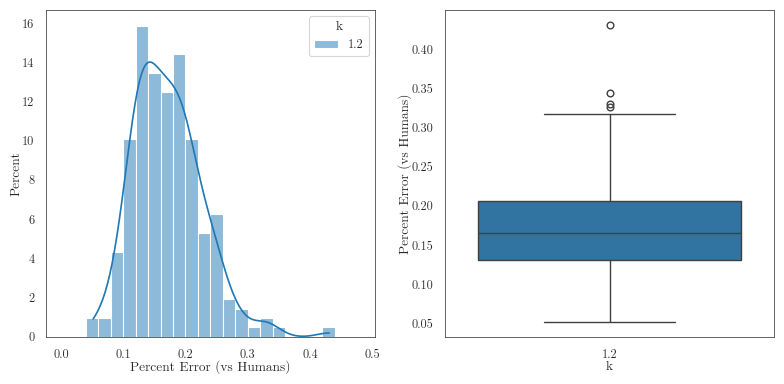

In [14]:
z05k12 = pd.read_pickle(f"data/RL_z05k12.pkl").query("type=='model-RL'")
combined = pd.concat([z05k12], ignore_index=True)

dfs = []
columns = ['type', 'sid', 'z', 'k', 'percent error']
for k in combined['k'].unique():
    for sid in combined['sid'].unique():
        subdata = combined.query("k==@k & sid==@sid")
        z = subdata['z'].unique()[0]
        errors = subdata['error'].to_numpy()
        if len(errors)==0:
            print(f"missing k={k} sid={sid}")
            continue
        percent_error = np.sum(errors) / len(errors)
        df = pd.DataFrame([['model-RL', sid, str(z), str(k), percent_error]], columns=columns)
        dfs.append(df)
reduced = pd.concat(dfs, ignore_index=True)

fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(8,4))
bins = np.arange(0.0, 0.5, 0.02)
ks = reduced['k'].unique()

sns.histplot(reduced, x='percent error', hue='k', ax=axes[0], palette=palette[:len(ks)], stat='percent', bins=bins, kde=True, common_norm=False)
sns.boxplot(reduced, x='k', y='percent error', hue='k', ax=axes[1], palette=palette[:len(ks)])
axes[0].set(xlabel="Percent Error (vs Humans)") 
axes[1].set(xlabel="k", ylabel='Percent Error (vs Humans)') 
plt.tight_layout()
fig.savefig("plots/rl_errors_zk.png", dpi=600)

# Statistical models

In [15]:
fitted_NEF_WM = pd.read_pickle(f"data/NEF-WM_z05k12.pkl")
fitted_RL1 = pd.read_pickle(f"data/RL1_all.pkl")
combined = pd.concat([fitted_RL1, fitted_NEF_WM], ignore_index=True)

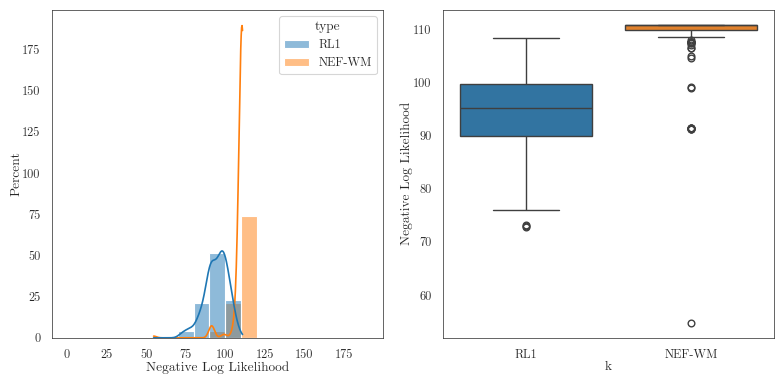

In [16]:
fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(8,4))
bins = np.arange(0, 200, 10)
types = combined['type'].unique()

sns.histplot(combined, x='neg-log-likelihood', hue='type', ax=axes[0], palette=palette[:len(types)],
             stat='percent', bins=bins, kde=True, common_norm=False)
sns.boxplot(combined, x='type', y='neg-log-likelihood', hue='type', ax=axes[1], palette=palette[:len(types)])
axes[0].set(xlabel="Negative Log Likelihood") 
axes[1].set(xlabel="k", ylabel='Negative Log Likelihood') 
plt.tight_layout()
fig.savefig("plots/fitted.png", dpi=600)

## Rerun fitted models

In [31]:
fitted = pd.read_pickle(f"data/RL1_all.pkl")
# fitted = pd.read_pickle(f"data/NEF-WM_z05k12.pkl")
dfs = []
model_types = ["RL1"]  # , "RL2"]
# model_types = ["NEF-WM"]  # , "RL2"]
sids = pd.read_pickle(f"data/behavior.pkl")['sid'].unique()
for model_type in model_types:
    for sid in [1]:  # sids:
        print(f"{model_type}, {sid}")
        data = rerun(fitted, model_type, sid)
        dfs.append(data)
rerun_data = pd.concat(dfs, ignore_index=True)
rerun_data.to_pickle(f"data/rerun_fitted_mathematical_models.pkl")

RL1, 1
